In [1]:
from numpy import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pprint import pprint

 v_ef = freq * 7.216969696969696e-05 + -0.00033333333333335544
 mu0 = 1.2566370614359173e-06
 mu = 1.1958712384959098e-06


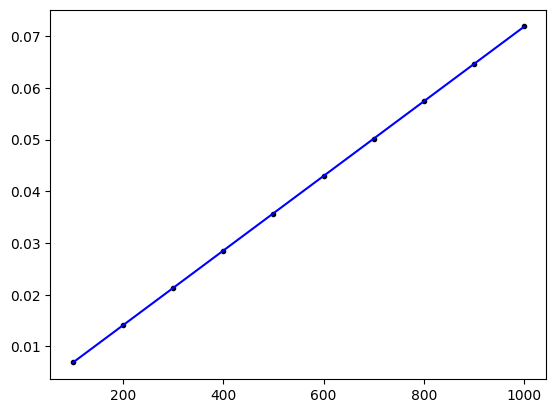

In [2]:
D = 41 # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = 300 # número de vueltas de la espira
N = 485 # N/L = 485 vueltas/m
I_ef = 50 / 1000 # A (mA/1000)

freq = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]) # frecuencias comprendidas entre 100 Hz y 1KHz
v_ef = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(freq, v_ef, 1)
print(f" v_ef = freq * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * A * n * N * I_ef)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(freq, v_ef, 'k.')
plt.plot( freq, a + b * freq, 'b-')


In [3]:
# http://astropython.blogspot.com/2011/12/calculating-prediction-band-of-linear.html
# https://www.youtube.com/watch?v=o0UESA3UZss
# https://codereview.stackexchange.com/questions/84414/obtaining-prediction-bands-for-regression-model

In [4]:
# https://espanol.libretexts.org/Quimica/Qu%C3%ADmica_Anal%C3%ADtica/Quimiometr%C3%ADa_usando_R_(Harvey)/08%3A_Calibraci%C3%B3n_de_datos/8.01%3A_Regresi%C3%B3n_lineal_no_ponderada_con_errores_en_y

import numpy
import scipy

X = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ])
Y = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000

n = size(X)
sum_X = sum(X)
sum_Y = sum(Y)
sum_XX = sum(X ** 2)
sum_XY = sum(X * Y)

b1 = ( n * sum_XY - sum_X * sum_Y ) / ( n * sum_XX - sum_X ** 2 )
b0 = ( sum_Y - b1 * sum_X ) / n

print(f"b0 = {b0}, b1 = {b1}")

est_Y = b0 + b1 * X
avg_X = average(X)

sr = sqrt( sum( (Y - est_Y) ** 2 ) / (n - 2) )

sb1 = sqrt( (sr ** 2) / sum( (X - avg_X) ** 2 ) )
sb0 = sqrt( ( (sr ** 2) * sum_XX ) / ( n * sum( (X - avg_X) ** 2 ) ) )
print(f"sr = {sr}, sb0 = {sb0}, sb1 = {sb1}")

alpha = 0.05
t = scipy.stats.t.ppf(1. - alpha / 2., n - 2)
print(f"α = {alpha} → t = {t} → β0 = {b0} ± {t * sb0}, β1 = {b1} ± {t * sb1}")

b0 = -0.00033333333333330774, b1 = 7.216969696969693e-05
sr = 7.092462922217741e-05, sb0 = 4.8450745582239426e-05, sb1 = 7.808544682863955e-08
α = 0.05 → t = 2.306004135204166 → β0 = -0.00033333333333330774 ± 0.00011172761966636909, β1 = 7.216969696969693e-05 ± 1.800653632861078e-07


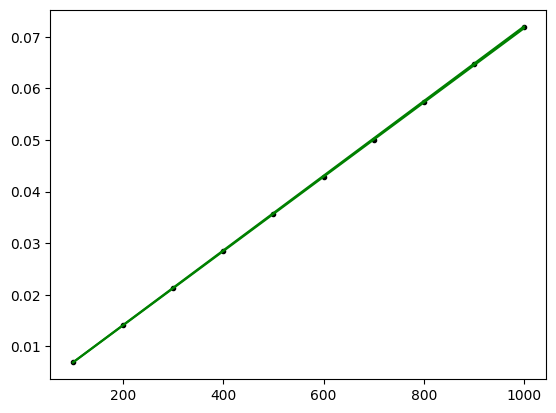

In [5]:
f = plt.figure()
plt.plot(X, Y, 'k.')
#plt.plot( X, b0 + b1 * X, 'b-')
plt.plot( X, b0 + (b1 - t * sb1) * X, 'g-')
plt.plot( X, b0 + (b1 + t * sb1) * X, 'g-')

In [6]:
import numpy
import scipy

def predband(xd, yd, a, b, conf=0.95, x=None):
    """
Calculates the prediction band of the linear regression model at the desired confidence
level.
Clarification of the difference between confidence and prediction bands:
"The 2sigma confidence interval is 95% sure to contain the best-fit regression line.
This is not the same as saying it will contain 95% of the data points. The prediction bands are
further from the best-fit line than the confidence bands, a lot further if you have many data
points. The 95% prediction interval is the area in which you expect 95% of all data points to fall."
(from http://graphpad.com/curvefit/linear_regression.htm)
Arguments:
- conf: desired confidence level, by default 0.95 (2 sigma)
- xd,yd: data arrays
- a,b: linear fit parameters as in y=ax+b
- x: (optional) array with x values to calculate the confidence band. If none is provided, will
 by default generate 100 points in the original x-range of the data.
 
Usage:
>>> lpb,upb,x=nemmen.predband(all.kp,all.lg,a,b,conf=0.95)
calculates the prediction bands for the given input arrays
>>> pylab.fill_between(x, lpb, upb, alpha=0.3, facecolor='gray')
plots a shaded area containing the prediction band  
Returns:
Sequence (lpb,upb,x) with the arrays holding the lower and upper confidence bands
corresponding to the [input] x array.
References:
1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear Regression, Gerard
E. Dallal, Ph.D.
Rodrigo Nemmen
v1 Dec. 2011
v2 Jun. 2012: corrected bug in dy.
    """
    alpha = 1. - conf   # significance
    n = xd.size   # data sample size
    if x is None:
        x = numpy.linspace(xd.min(), xd.max(), 100)
    # Predicted values (best-fit model)
    y = b * x + a
    # Auxiliary definitions
    # scatterfit: Std. deviation of an individual measurement (Bevington, eq. 6.15)  
    sd = sqrt( 1. / ( size(x) - 2. ) * sum( (y - b * x - a) ** 2 ) ) # Scatter fit of data about the model
    sxd = numpy.sum((xd - xd.mean()) ** 2)
    sx = (x - xd.mean()) ** 2 # array
    # Quantile of Student's t distribution for p = 1 - alpha / 2
    q = scipy.stats.t.ppf(1. - alpha / 2., n - 2)
    # Prediction band
    dy = q * sd * numpy.sqrt( 1.+1./n + sx/sxd )
    upb = y + dy    # Upper prediction band
    lpb = y - dy    # Lower prediction band
    return lpb, upb, x


[0.00688364 0.01410061 0.02131758 0.02853455 0.03575152 0.04296848
 0.05018545 0.05740242 0.06461939 0.07183636]
[0.00688364 0.01410061 0.02131758 0.02853455 0.03575152 0.04296848
 0.05018545 0.05740242 0.06461939 0.07183636]
2.7755575615628914e-17


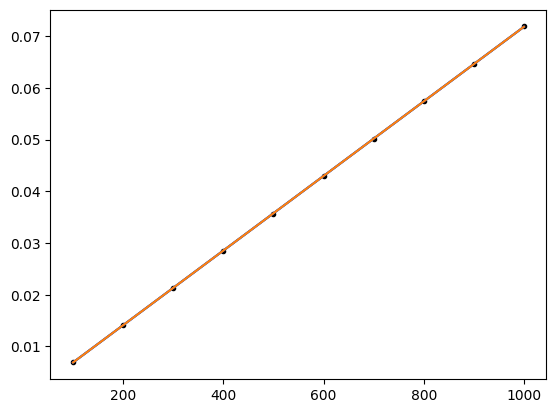

In [7]:
lpb, upb, x = predband(freq, v_ef, a, b, x=freq)

f = plt.figure()

plt.plot(freq, v_ef, 'k.')
plt.plot( freq, a + b * freq, 'b-')

plt.plot(x, lpb)
plt.plot(x, upb)

print(upb)
print(lpb)

print(max(upb - lpb))


In [8]:
from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

freq = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]) # frecuencias comprendidas entre 100 Hz y 1KHz
v_ef = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000 # A (mA/1000)

slope, intercept, r_value, p_value, std_err = stats.linregress(freq, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

err = 1 / (2 * pi * A * n * N * I_ef) * (std_err + slope / I_ef * 0.0001)
print(f"error={err}")

slope=7.216969696969698e-05, intercept=-0.00033333333333333826, r_value=0.999995317396591, p_value=2.1034157662111526e-21, std_err=7.808544682836994e-08
error=1.1056917832683466e-07


 v_ef = A * 55.74108069613493 + -0.0006874118420072849
 mu0 = 1.2566370614359173e-06
 mu = 1.2194458455084672e-06


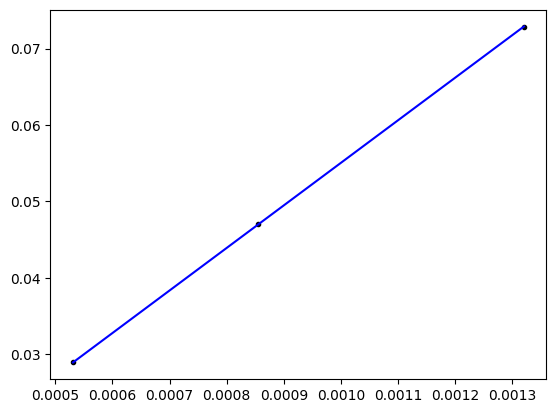

In [9]:
D = array([ 26, 33, 41 ]) # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = 300 # número de vueltas de la espira
freq = 1000 # Hz
v_ef = array([ 28.9, 47, 72.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(A, v_ef, 1)
print(f" v_ef = A * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * freq * n * N * I_ef)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(A, v_ef, 'k.')
plt.plot( A, a + b * A, 'b-')


In [10]:
from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

slope, intercept, r_value, p_value, std_err = stats.linregress(A, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

slope=55.74108069613493, intercept=-0.0006874118420072961, r_value=0.9999998857330004, p_value=0.00030433754780227426, std_err=0.026647153980924335


 v_ef = n * 0.0002444999999999999 + -0.0003666666666666325
 mu0 = 1.2566370614359173e-06
 mu = 1.2154291763273742e-06


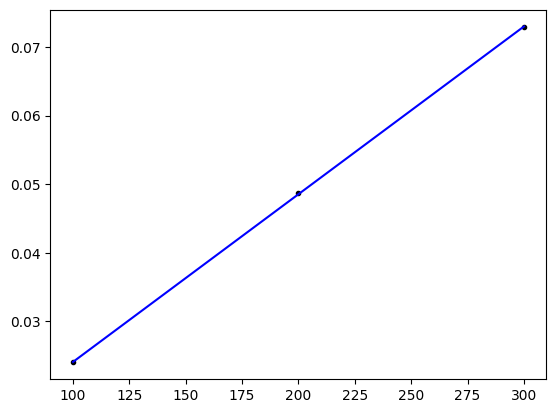

In [11]:
D = 41 # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = array([ 100, 200, 300 ]) # número de vueltas de la espira
freq = 1000 # Hz
v_ef = array([ 24, 48.7, 72.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(n, v_ef, 1)
print(f" v_ef = n * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * A * N * I_ef * freq)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(n, v_ef, 'k.')
plt.plot( n, a + b * n, 'b-')


In [12]:
from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

slope, intercept, r_value, p_value, std_err = stats.linregress(n, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

slope=0.00024450000000000003, intercept=-0.0003666666666666679, r_value=0.9999825755255122, p_value=0.0037581628560091574, std_err=1.443375672970692e-06


In [13]:
# https://espanol.libretexts.org/Quimica/Qu%C3%ADmica_Anal%C3%ADtica/Quimiometr%C3%ADa_usando_R_(Harvey)/08%3A_Calibraci%C3%B3n_de_datos/8.01%3A_Regresi%C3%B3n_lineal_no_ponderada_con_errores_en_y

#X = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ])
#Y = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000

X = array([ 0.000, 0.100, 0.200, 0.300, 0.400, 0.500 ])
Y = array([ 0.00, 12.36, 24.83, 35.91, 48.79, 60.42 ])

n = size(X)
sum_X = sum(X)
sum_Y = sum(Y)
sum_XX = sum(X ** 2)
sum_XY = sum(X * Y)

b1 = ( n * sum_XY - sum_X * sum_Y ) / ( n * sum_XX - sum_X ** 2 )
b0 = ( sum_Y - b1 * sum_X ) / n

print(f"b0 = {b0}, b1 = {b1}")
# b1, b0 = 120.71, 0.21

est_Y = b0 + b1 * X
avg_X = average(X)

sr = sqrt( sum( (Y - est_Y) ** 2 ) / (n - 2) )
# sr = 0.4035

sb1 = sqrt( (sr ** 2) / sum( (X - avg_X) ** 2 ) )
sb0 = sqrt( ( (sr ** 2) * sum_XX ) / ( n * sum( (X - avg_X) ** 2 ) ) )
#sb1, sb2 = 0.965, 0.292
print(f"sr = {sr}, sb0 = {sb0}, sb1 = {sb1}")


alpha = 0.05
t = scipy.stats.t.ppf(1. - alpha / 2., n - 2)
print(f"t = {t}, β0 = {b0} ± {t * sb0}, β1 = {b1} ± {t * sb1}")

b0 = 0.2085714285714507, b1 = 120.7057142857142
sr = 0.40329712549009356, sb0 = 0.29188503001747074, sb1 = 0.964064524896166
t = 2.7764451051977987, β0 = 0.2085714285714507 ± 0.8104027628725192, β1 = 120.7057142857142 ± 2.6766722312428013
